## Import Libraries Packages, Downloads

In [1]:
#manipulation and plotting libraries
import numpy as np
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math as mt

warnings.filterwarnings('ignore')

In [2]:
#ML libraries
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.ensemble import RandomForestClassifier

## Loading and Processing Data
`Note: (Because none of the processing we are doing involves imputation or such, we are doing the processing before the split)`

In [3]:
warnings.filterwarnings('ignore')
#read the cleaned data

Data = pd.read_csv("/kaggle/input/bus-data/formatted_data.csv")

In [4]:
Data.head()

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,How_Long_Delayed,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Incident_Number,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,11/05/2015 08:10:00 AM,11/05/2015 08:12:00 AM,New Jersey,...,max,11,Yes,No,Yes,11/05/2015 08:12:00 AM,NaN,11/05/2015 08:12:14 AM,Running Late,School-Age
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,11/05/2015 08:10:00 AM,11/05/2015 08:12:00 AM,Manhattan,...,0-30,2,Yes,Yes,No,11/05/2015 08:12:00 AM,NaN,11/05/2015 08:13:34 AM,Running Late,School-Age
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,11/05/2015 08:09:00 AM,11/05/2015 08:13:00 AM,Bronx,...,0-30,8,Yes,Yes,Yes,11/05/2015 08:13:00 AM,NaN,11/05/2015 08:13:22 AM,Running Late,Pre-K
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,11/05/2015 08:12:00 AM,11/05/2015 08:14:00 AM,Manhattan,...,0-30,6,No,No,No,11/05/2015 08:14:00 AM,NaN,11/05/2015 08:14:04 AM,Running Late,School-Age
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,02116,11/05/2015 08:13:00 AM,11/05/2015 08:14:00 AM,Manhattan,...,max,6,No,No,No,11/05/2015 08:14:00 AM,NaN,11/05/2015 08:14:08 AM,Running Late,School-Age


## Plotting

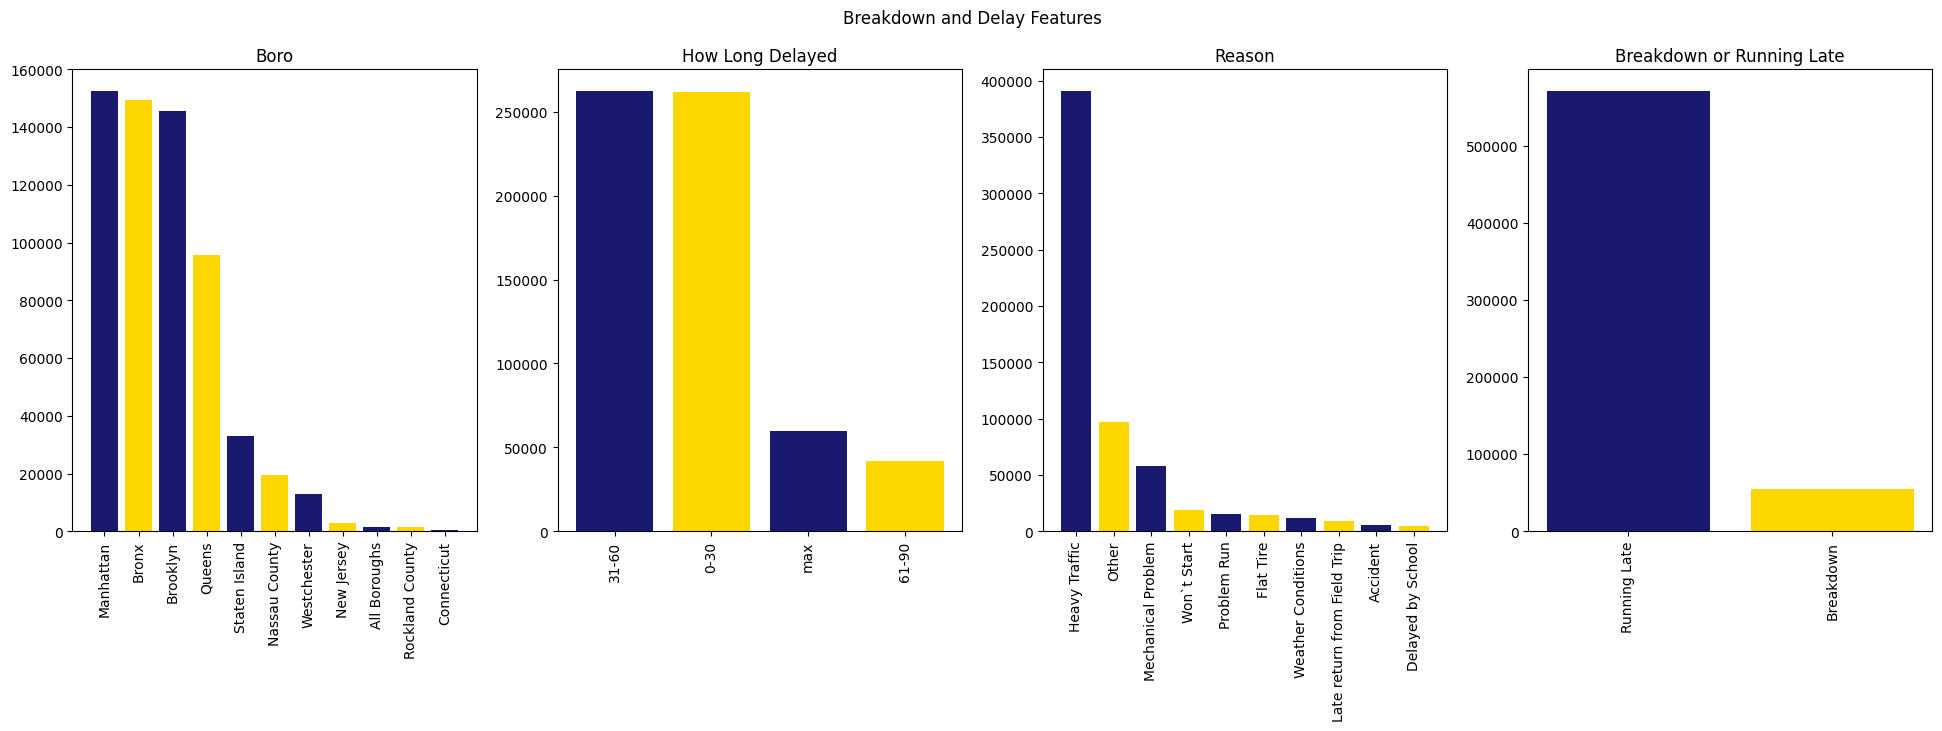

In [5]:
#warnings.filterwarnings('ignore')
#plot some EDA visuals
columns_to_plot_Data = ['Boro','How_Long_Delayed' ,'Reason', 'Breakdown_or_Running_Late']

fig, axs = plt.subplots(1,4, figsize=(24, 6))
fig.suptitle("Breakdown and Delay Features")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()

colors = ['midnightblue', 'gold']
i = 0
for column_name in columns_to_plot_Data:

    counts = Data[column_name].value_counts()
    
    # Rotate the tick labels in the second subplot
    axs[i].bar(counts.index, counts.values, color = colors)
    axs[i].set_title(f"{column_name.replace('_', ' ')}")
    axs[i].set_xticklabels(counts.index, rotation=90)
    i += 1

#plt.savefig('breakdown_figures.pdf', bbox_inches = "tight")


In [6]:
#defining a preprocessing function to prep data for ml tasks
def process(df): 

    #copy dataframe
    data = df.copy()
    #data.columns = data.columns.astype(str)

    #making a dictionary since we need to do a lot of conversion
    to_binary = {'Yes':1, 'No':0}

    #dropping columns we won't be able to use
    data = data.drop(['Busbreakdown_ID', 'Created_On', 
            'Informed_On','Incident_Number', 
            'Last_Updated_On', 'School_Age_or_PreK', 
            'School_Year', 'Route_Number', 'Schools_Serviced',
            'Run_Type', 'Bus_No', 'Bus_Company_Name'], axis = 1)
    
    data = data.dropna()

    #mapping literals to binary values
    data['Breakdown_or_Running_Late'] = data['Breakdown_or_Running_Late'].map({'Breakdown':1, 'Running Late':0})
    data['Has_Contractor_Notified_Parents'] = data['Has_Contractor_Notified_Parents'].map(to_binary)
    data['Has_Contractor_Notified_Schools'] = data['Has_Contractor_Notified_Schools'].map(to_binary)
    data['Have_You_Alerted_OPT'] = data['Have_You_Alerted_OPT'].map(to_binary)

    #getting month/date values
    data['Occurred_On'] = pd.to_datetime(data['Occurred_On'])
    data['Year'] = data['Occurred_On'].dt.year
    data['Month'] = data['Occurred_On'].dt.month
    data['Day'] = data['Occurred_On'].dt.day
    data['Hour'] = data['Occurred_On'].dt.hour
    data['Mins'] = data['Occurred_On'].dt.minute
    data['Weekday'] = data['Occurred_On'].dt.weekday


    data["sin_month"] = np.sin(2*np.pi*data["Month"]/max(data["Month"]))
    data["cos_month"] = np.cos(2*np.pi*data["Month"]/max(data["Month"]))
    data["sin_hour"] = np.sin(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["cos_hour"] = np.cos(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["sin_mins"] = np.sin(2*np.pi*data["Mins"]/max(data["Mins"]))
    data["cos_mins"] = np.cos(2*np.pi*data["Mins"]/max(data["Mins"]))

    #one hot encode boro
    #data['Boro'] = data['Boro'].fillna('None')
    for boro in data['Boro'].unique():
        data[boro] = (data['Boro'] == boro).astype(int)

    # one hot encode breakdown reason
    for reason in data['Reason'].unique():
        data[reason] = (data['Reason'] == reason).astype(int)

    data = data.drop(['Boro'], axis = 1)
    data = data.drop(['Reason'], axis = 1)

    #plot some features

    i = 0
    columns_to_plot_df = ['Month', 'Day', 'Hour', 'Weekday']

    fig, axs = plt.subplots(1,4, figsize=(24, 6))
    fig.suptitle("Time Series Features")
    fig.subplots_adjust(hspace = .5, wspace=.2)
    axs = axs.ravel()
    colors = ['midnightblue', 'gold']

    for column_name in columns_to_plot_df:
        
        counts = data[column_name].value_counts().sort_index()
        
        # Rotate the tick labels in the second subplot
        axs[i].bar(counts.index, counts.values, color = colors)
        axs[i].set_title(f"{column_name}")
        i += 1

    data = data.drop(['Occurred_On', 'Month', 'Day', 'Hour', 'Mins'], axis = 1)

    #plt.savefig('Time_features.pdf', bbox_inches = "tight")

    return data


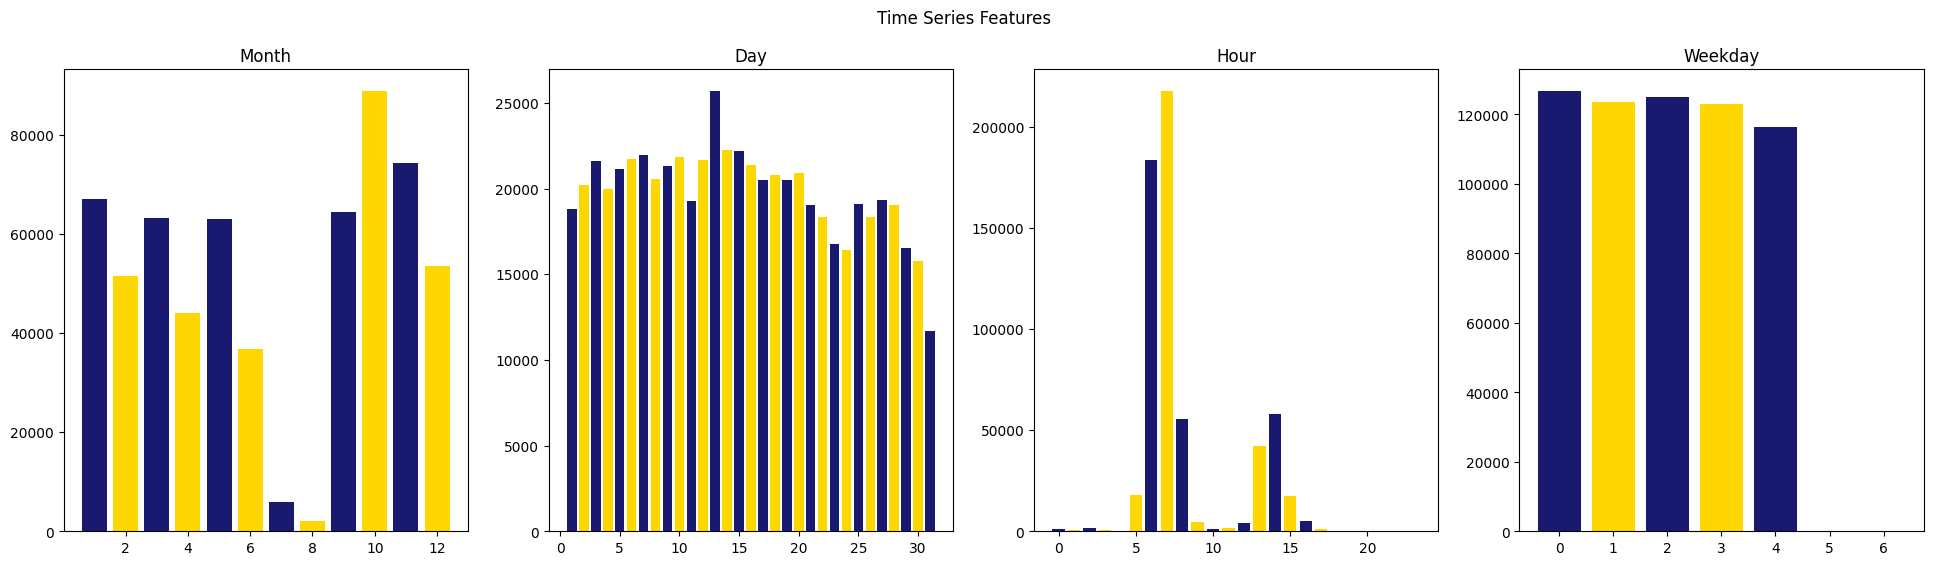

In [7]:
#Process the data
df = process(Data)


In [8]:
df.head()

,How_Long_Delayed,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Breakdown_or_Running_Late,Year,Weekday,sin_month,cos_month,...,Heavy Traffic,Other,Won`t Start,Flat Tire,Mechanical Problem,Problem Run,Accident,Late return from Field Trip,Delayed by School,Weather Conditions
0,max,11,1,0,1,0,2015,3,-0.5,0.866025,...,1,0,0,0,0,0,0,0,0,0
1,0-30,2,1,1,0,0,2015,3,-0.5,0.866025,...,1,0,0,0,0,0,0,0,0,0
2,0-30,8,1,1,1,0,2015,3,-0.5,0.866025,...,1,0,0,0,0,0,0,0,0,0
3,0-30,6,0,0,0,0,2015,3,-0.5,0.866025,...,1,0,0,0,0,0,0,0,0,0
4,max,6,0,0,0,0,2015,3,-0.5,0.866025,...,1,0,0,0,0,0,0,0,0,0


### Train Test Split

In [9]:
#prep X and y data for the delay vs. breakdown classification task
# won't use how_long_delayed for this task
X = df.drop(['How_Long_Delayed', 'Breakdown_or_Running_Late'], axis = 1)
y = df['Breakdown_or_Running_Late']

X_train, X_test,y_train, y_test = train_test_split(X,y, test_size= .1, random_state = 42)

## Building a Baseline Classifier
#### 1) (Almost) Random Guessing


In [10]:
# Libraries
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import statistics as stat
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay, confusion_matrix

In [11]:
#dummy classifier to predict the most frequent
dummyclf = DummyClassifier(strategy='most_frequent')
dummyclf.fit(X_train, y_train)
guess = dummyclf.predict(X_test)
print('dummy',accuracy_score(y_test, guess))



dummy 0.9107639736392482


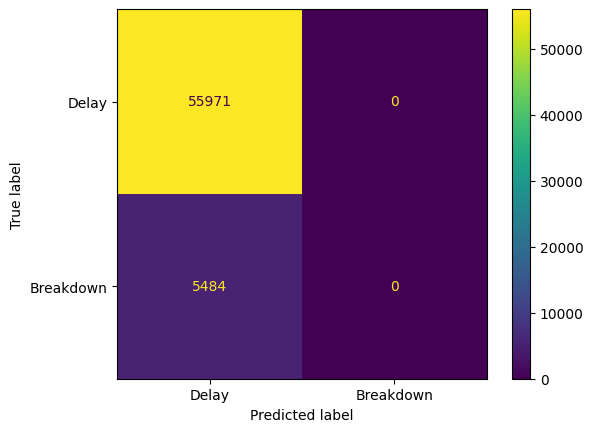

In [12]:
# confusion matrix display for dummy classifier
conf_mat = confusion_matrix(y_test, guess)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Delay', 'Breakdown'])
disp.plot(values_format='.0f')
plt.savefig('/kaggle/working/dummy_confusion_matrix.pdf')
plt.show()

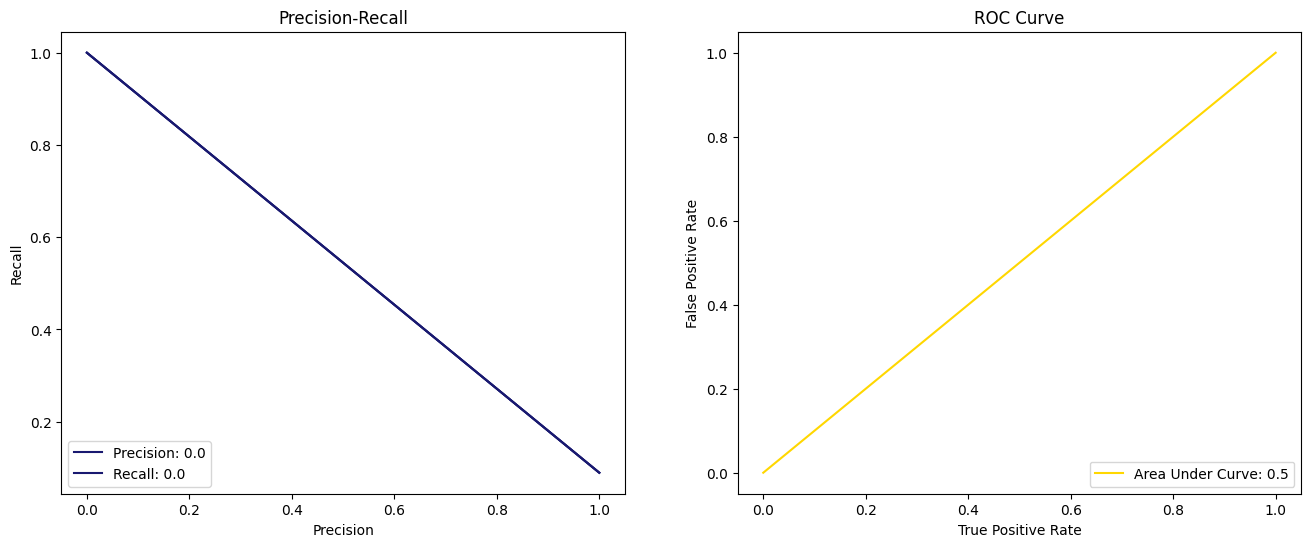

In [13]:
# plot roc and AUC curves for the dummy clf
ig, axs = plt.subplots(1,2, figsize=(16, 6))

fig.suptitle("Precision and Recall Curves For Random Forest Classifier")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
colors = ['midnightblue', 'gold']


    
classifier = dummyclf


y_pred = classifier.predict_proba(X_test)[:,1]


prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
precision, recall, threshholds = precision_recall_curve(y_test, y_pred)


axs[0].plot(recall, precision, color = 'midnightblue', label = f"Precision: {prec_score.round(4)}")
axs[0].plot(recall, precision, color = 'midnightblue', label = f"Recall: {rec_score.round(4)}")
axs[0].plot(recall, precision, color = 'midnightblue')
axs[0].set_title(f"Precision-Recall")
axs[0].set_ylabel('Recall')
axs[0].set_xlabel('Precision')
axs[0].legend(loc = 'lower left')



    
classifier = dummyclf

y_pred = classifier.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

axs[1].plot(fpr, tpr,  color = 'gold', label = f"Area Under Curve: {auc.round(4)}")
axs[1].set_title(f"ROC Curve")
axs[1].set_ylabel('False Positive Rate')
axs[1].set_xlabel('True Positive Rate')
axs[1].legend(loc = 'lower right')

plt.savefig('/kaggle/working/dummy_ROC_Curves.pdf', bbox_inches = "tight")
plt.show()


In [14]:
#calculate dummy scores
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

scores = pd.DataFrame()

from sklearn.metrics import RocCurveDisplay

    
classifier = dummyclf

y_pred = classifier.predict(X_test)


auc_scores.append(roc_auc_score(y_test, y_pred))
precision_scores.append(precision_score(y_test, y_pred))
recall_scores.append(recall_score(y_test, y_pred))
f1_scores.append(f1_score(y_test, y_pred))
accuracy_scores.append(accuracy_score(y_test, y_pred))


scores['Accuracy'] = accuracy_scores
scores['Recall'] = recall_scores
scores['Precision'] = precision_scores
scores['F1'] = f1_scores
scores['AUC'] = auc_scores

scores.round(4).to_csv('/kaggle/working/dummy_metrics.csv', index=False)
print(scores)

   Accuracy  Recall  Precision   F1  AUC
0  0.910764     0.0        0.0  0.0  0.5


#### 2) Logistic Regression

In [15]:
# logistic regression pipeline with imbalanced learn
pipe = imbPipeline( steps = 
                [
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree = 1)),
                    ('sample', SMOTE(random_state= 42)),
                    ('mod', LogisticRegression(random_state= 42, class_weight='balanced'))

                ])
# define grid search with hyperparameter tuning
gridcv = GridSearchCV(pipe, 
                        param_grid = {
                                        'mod__C': [0.1, 1, 10, 100],
                                        'sample': [RandomOverSampler(random_state=42)],
                                        'poly__degree':[1,2],
                                        'scaler': [StandardScaler()],

                                    },
                        return_train_score = True,
                        cv = 5,
                        verbose= 3,
                        n_jobs=2)
gridlr = GridSearchCV(pipe, 
                        param_grid = {
                                        'mod__C': [0.1],# 1, 10, 100],
                                        'sample': [RandomOverSampler(random_state=42)],
                                        'poly__degree':[1],
                                        'scaler': [StandardScaler()],

                                    },
                        return_train_score = True,
                        cv = 2,
                        verbose= 3,
                        n_jobs=2)
#from previous fits, the results are included below

gridlr.fit(X_train, y_train)


print(f'Logistic Regression: {gridlr.score(X_test, y_test)}')
print(gridlr.best_params_)
# best params 'mod__C': 0.1, 'poly__degree': 1, 
#'sample': RandomOverSampler(random_state=42), 'scaler': StandardScaler()
# test score: 0.8945313135586326

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Logistic Regression: 0.892539256366447
{'mod__C': 0.1, 'poly__degree': 1, 'sample': RandomOverSampler(random_state=42), 'scaler': StandardScaler()}


In [16]:
#define imbalanced pipeline
pipe = imbPipeline( steps = 
                [
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree = 1)),
                    ('sample', SMOTE(random_state= 42)),
                    ('mod', RandomForestClassifier(random_state= 42, class_weight='balanced'))

                ])

# define grid search used for parameter tuning
gridcv = GridSearchCV(pipe, 
                        param_grid = {
                                        'mod__max_depth': [5, 10, 15],
                                        'mod__n_estimators': [100, 200],
                                        'sample': [RandomOverSampler(random_state=42)],
                                        'poly__degree':[1, 2],
                                        'scaler': [StandardScaler()],

                                    },
                        return_train_score = True,
                        cv = 5,
                        verbose= 3,
                        n_jobs = 2)
# use the best parameters, and train 
gridcv = GridSearchCV(pipe, 
                        param_grid = {
                                        'mod__max_depth': [15],
                                        'mod__n_estimators': [200],
                                        'sample': [RandomOverSampler(random_state=42)],
                                        'poly__degree':[2],
                                        'scaler': [StandardScaler()],

                                    },
                        return_train_score = True,
                        cv = 2,
                        verbose= 3,
                        n_jobs = 2)
gridcv.fit(X_train, y_train)
print(f'Random Forest: {gridcv.score(X_test, y_test)}')
print(gridcv.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END mod__C=0.1, poly__degree=1, sample=RandomOverSampler(random_state=42), scaler=StandardScaler();, score=(train=0.894, test=0.894) total time=   3.2s
[CV 2/2] END mod__max_depth=15, mod__n_estimators=200, poly__degree=2, sample=RandomOverSampler(random_state=42), scaler=StandardScaler();, score=(train=0.929, test=0.918) total time=18.0min
[CV 2/2] END mod__C=0.1, poly__degree=1, sample=RandomOverSampler(random_state=42), scaler=StandardScaler();, score=(train=0.893, test=0.893) total time=   3.1s
[CV 1/2] END mod__max_depth=15, mod__n_estimators=200, poly__degree=2, sample=RandomOverSampler(random_state=42), scaler=StandardScaler();, score=(train=0.927, test=0.917) total time=18.5min
Random Forest: 0.9155805060613457
{'mod__max_depth': 15, 'mod__n_estimators': 200, 'poly__degree': 2, 'sample': RandomOverSampler(random_state=42), 'scaler': StandardScaler()}


# Evaluation

In [17]:
# Libraries
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import statistics as stat
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay, confusion_matrix

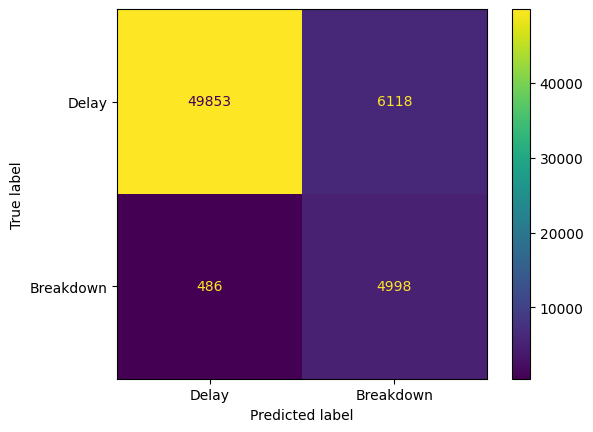

In [18]:
# create a confusion matrix display for final model
y_pred = gridlr.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Delay', 'Breakdown'])
disp.plot(values_format='.0f')
plt.savefig('/kaggle/working/log_confusion_matrix.pdf')
plt.show()

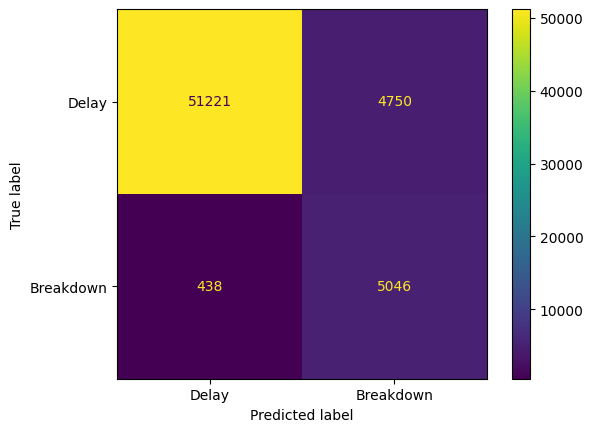

In [19]:
# create a confusion matrix display for final model
y_pred = gridcv.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Delay', 'Breakdown'])
disp.plot(values_format='.0f')
plt.savefig('/kaggle/working/model_confusion_matrix.pdf')
plt.show()

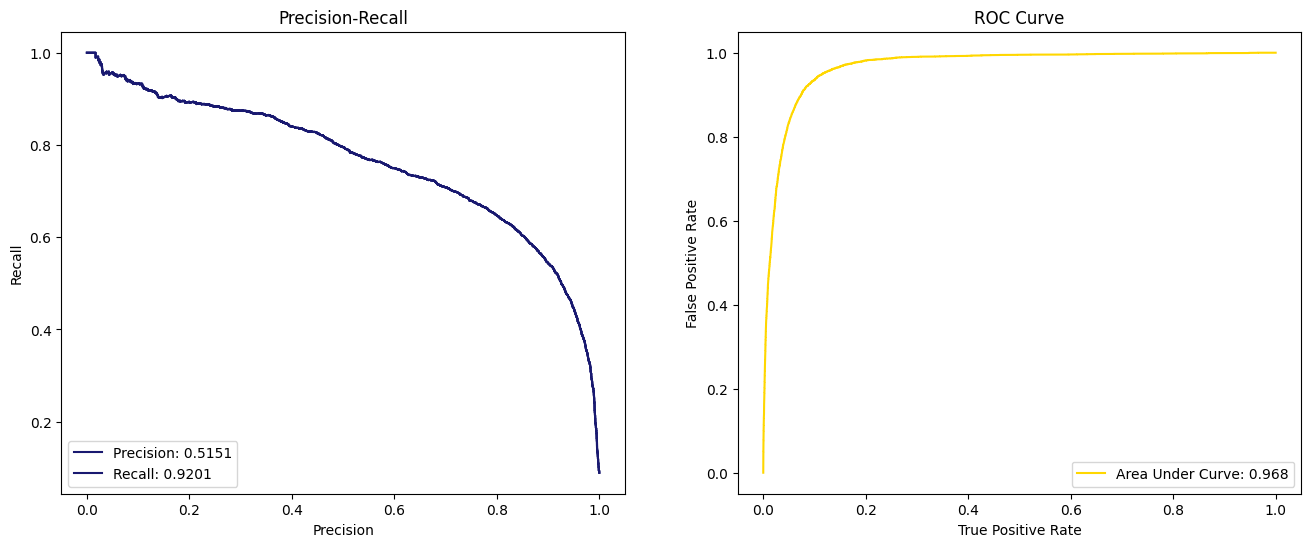

In [20]:
ig, axs = plt.subplots(1,2, figsize=(16, 6))
#create the precision recall curves
fig.suptitle("Precision and Recall Curves For Random Forest Classifier")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
colors = ['midnightblue', 'gold']


    
classifier = gridcv


y_pred = classifier.predict(X_test)

# calculate the true precision and recall scores, and then the curve
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
y_pred = classifier.predict_proba(X_test)[:,1]
precision, recall, threshholds = precision_recall_curve(y_test, y_pred)

#plot precision recall curve
axs[0].plot(recall, precision, color = 'midnightblue', label = f"Precision: {prec_score.round(4)}")
axs[0].plot(recall, precision, color = 'midnightblue', label = f"Recall: {rec_score.round(4)}")
axs[0].plot(recall, precision, color = 'midnightblue')
axs[0].set_title(f"Precision-Recall")
axs[0].set_ylabel('Recall')
axs[0].set_xlabel('Precision')
axs[0].legend(loc = 'lower left')



#calculating and plotting the ROC curve and calculating the AUC score    
classifier = gridcv

y_pred = classifier.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
#plot
axs[1].plot(fpr, tpr,  color = 'gold', label = f"Area Under Curve: {auc.round(4)}")
axs[1].set_title(f"ROC Curve")
axs[1].set_ylabel('False Positive Rate')
axs[1].set_xlabel('True Positive Rate')
axs[1].legend(loc = 'lower right')
#export figure
plt.savefig('/kaggle/working/ROC_Curves.pdf', bbox_inches = "tight")
plt.show()


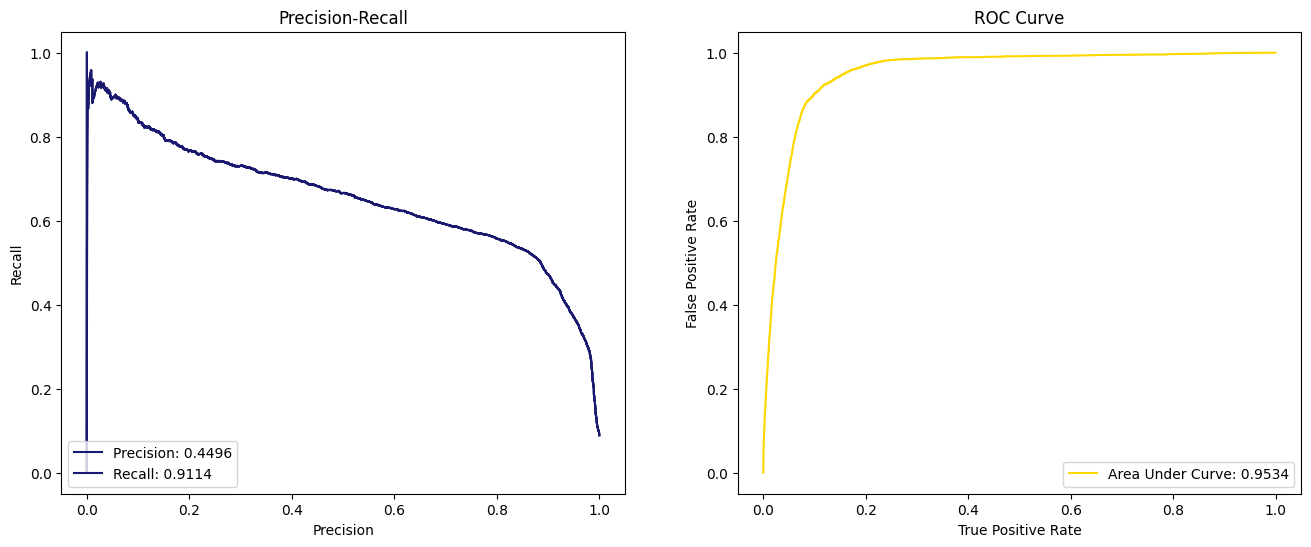

In [21]:
ig, axs = plt.subplots(1,2, figsize=(16, 6))
#create the precision recall curves
fig.suptitle("Precision and Recall Curves For Random Forest Classifier")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
colors = ['midnightblue', 'gold']


    
classifier = gridlr


y_pred = classifier.predict(X_test)

# calculate the true precision and recall scores, and then the curve
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
y_pred = classifier.predict_proba(X_test)[:,1]
precision, recall, threshholds = precision_recall_curve(y_test, y_pred)

#plot precision recall curve
axs[0].plot(recall, precision, color = 'midnightblue', label = f"Precision: {prec_score.round(4)}")
axs[0].plot(recall, precision, color = 'midnightblue', label = f"Recall: {rec_score.round(4)}")
axs[0].plot(recall, precision, color = 'midnightblue')
axs[0].set_title(f"Precision-Recall")
axs[0].set_ylabel('Recall')
axs[0].set_xlabel('Precision')
axs[0].legend(loc = 'lower left')



#calculating and plotting the ROC curve and calculating the AUC score    
classifier = gridlr

y_pred = classifier.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
#plot
axs[1].plot(fpr, tpr,  color = 'gold', label = f"Area Under Curve: {auc.round(4)}")
axs[1].set_title(f"ROC Curve")
axs[1].set_ylabel('False Positive Rate')
axs[1].set_xlabel('True Positive Rate')
axs[1].legend(loc = 'lower right')
#export figure
plt.savefig('/kaggle/working/lr_ROC_Curves.pdf', bbox_inches = "tight")
plt.show()

In [22]:
## Metrics 


# computing the following metrics
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

scores = pd.DataFrame()

from sklearn.metrics import RocCurveDisplay

# classifier is the gridcv retrained on the best model    
classifier = gridlr

y_pred = classifier.predict(X_test)

#append scores to vectors
auc_scores.append(roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1]))
precision_scores.append(precision_score(y_test, y_pred))
recall_scores.append(recall_score(y_test, y_pred))
f1_scores.append(f1_score(y_test, y_pred))
accuracy_scores.append(accuracy_score(y_test, y_pred))

scores['Accuracy'] = accuracy_scores
scores['Recall'] = recall_scores
scores['Precision'] = precision_scores
scores['F1'] = f1_scores
scores['AUC'] = auc_scores
#export to file
scores.round(4).to_csv('/kaggle/working/lr_metrics.csv', index=False)

In [23]:
## Metrics 


# computing the following metrics
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

scores = pd.DataFrame()

from sklearn.metrics import RocCurveDisplay

# classifier is the gridcv retrained on the best model    
classifier = gridcv

y_pred = classifier.predict(X_test)

#append scores to vectors
auc_scores.append(roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1]))
precision_scores.append(precision_score(y_test, y_pred))
recall_scores.append(recall_score(y_test, y_pred))
f1_scores.append(f1_score(y_test, y_pred))
accuracy_scores.append(accuracy_score(y_test, y_pred))

scores['Accuracy'] = accuracy_scores
scores['Recall'] = recall_scores
scores['Precision'] = precision_scores
scores['F1'] = f1_scores
scores['AUC'] = auc_scores
#export to file
scores.round(4).to_csv('/kaggle/working/metrics.csv', index=False)